In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Sun Jan 28 21:10:09 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.223.02   Driver Version: 470.223.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   49C    P0    49W / 300W |     35MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Model Parts

In [3]:
from model.main.enc_prior_latent_quantizer_dec import Model
from model.encoder.net_64_encoder import Encoder
from model.prior.dalle_rand_prior import Prior
from model.latent.dalle_exclusive3_lse_latent import Latent
from model.quantizer.dalle_nearest_quantizer import Quantizer
from model.decoder.net_64_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *

### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.img_size = 64
hp.n_resblocks = 6
hp.z_dim = 64
hp.n_prior_embeddings = 512
hp.quantize = False
hp.prior_mu = 0.999
hp.z_activation = F.tanh
hp.M = hp.n_prior_embeddings

In [5]:
step = 0
device = 'cuda:0'

model_list = []
optimizer_list = []
for i in range(1):
    model = Model(Encoder(**hp), Prior(**hp), Latent(**hp), Quantizer(**hp), Decoder(**hp))
    model = model.to(device)
    model_list.append(model)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    optimizer_list.append(optimizer)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))

print('done')

encoder 1.2191162109375
encoder.encoder 1.2191162109375
prior 0.126953125
latent 0.001953125
quantizer 0.0
decoder 1.0611686706542969
decoder.decoder 1.0611686706542969
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train_dalle/train01.28-1_1e-0/'

!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, model_list, optimizer_list = load_model_list(save_dir, 660000, model_list, optimizer_list)

total 0


### Dataset

In [7]:
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CelebA

class MyCelebA(CelebA):
    """
    A work-around to address issues with pytorch's celebA dataset class.
    
    Download and Extract
    URL : https://drive.google.com/file/d/1m8-EBPgi5MRubrm6iQjafK2QMHDBMSfJ/view?usp=sharing
    """
    
    def _check_integrity(self) -> bool:
        return True

root = '/data'
train_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                       transforms.CenterCrop(148),
                                       transforms.Resize(hp.img_size),
                                       transforms.ToTensor(),])
train_dataset = MyCelebA(root, split='train', transform=train_transforms, download=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
print('done')

done


In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.permute(0, 2, 3, 1).data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(8):
        plt.subplot(1, 8, i+1)
        plt.imshow(_x[i])
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [10]:
def linear(start_value, end_value, current_index, start_index, end_index):
    if current_index > end_index:
        return end_value
    if current_index < start_index:
        return start_value

    grad = (end_value - start_value) / (end_index - start_index)
    y = start_value + grad * (current_index - start_index)

    return y

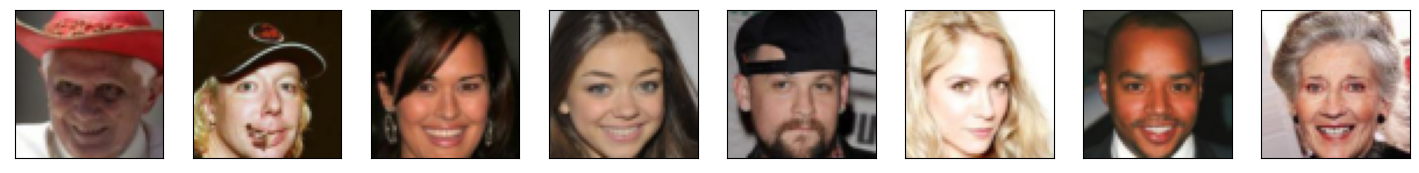

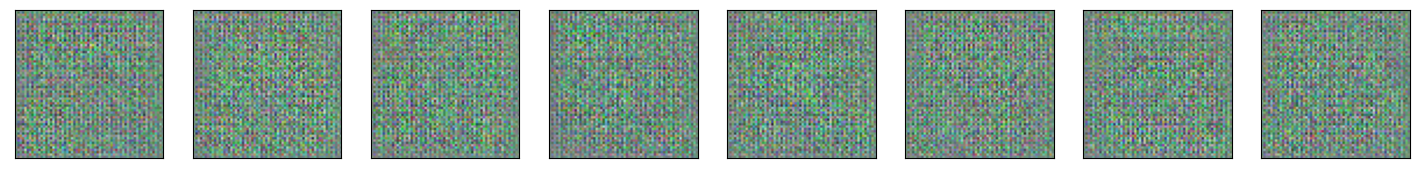

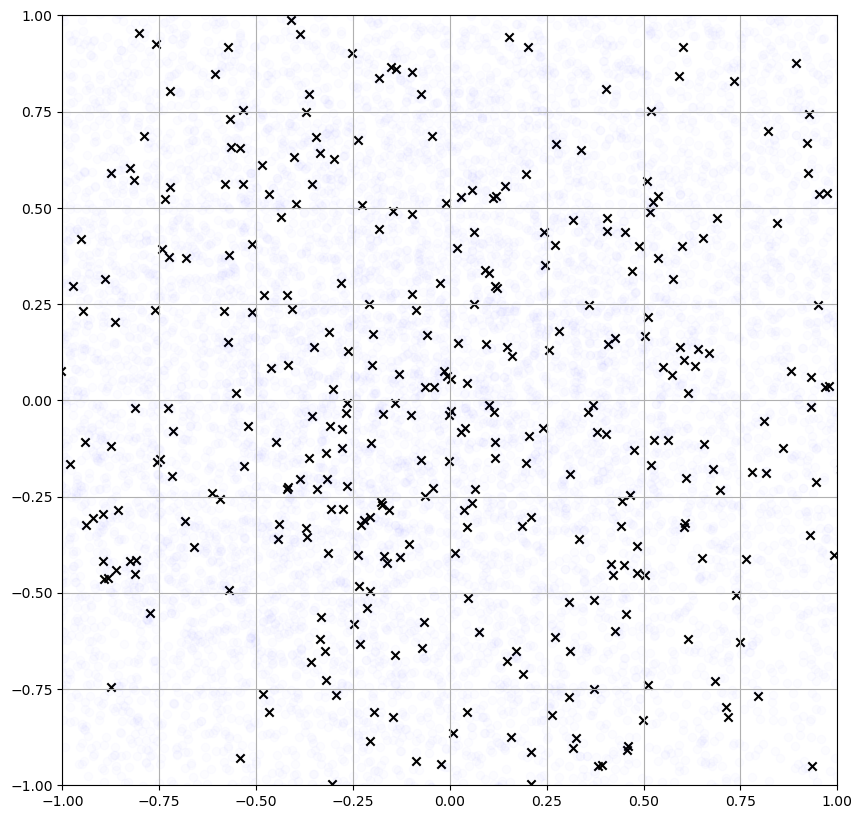

1
lse_loss 30.93170166015625
commit_loss 0.6196938753128052
recon_loss 0.1094895526766777
2
lse_loss 30.27175521850586
commit_loss 0.6090530753135681
recon_loss 0.1090562641620636
3
lse_loss 28.783973693847656
commit_loss 0.5866732597351074
recon_loss 0.10553281009197235
4
lse_loss 27.773622512817383
commit_loss 0.5750648379325867
recon_loss 0.10135523974895477
5
lse_loss 26.33298110961914
commit_loss 0.553041934967041
recon_loss 0.10673122107982635
6
lse_loss 25.033954620361328
commit_loss 0.5406073331832886
recon_loss 0.10209342837333679
7
lse_loss 23.72414779663086
commit_loss 0.5266874432563782
recon_loss 0.1026664674282074
8
lse_loss 22.170207977294922
commit_loss 0.5131644606590271
recon_loss 0.09874187409877777
9
lse_loss 20.813405990600586
commit_loss 0.5039693117141724
recon_loss 0.09431638568639755
10
lse_loss 19.507057189941406
commit_loss 0.49416568875312805
recon_loss 0.09503772854804993
11
lse_loss 17.651668548583984
commit_loss 0.4659580886363983
recon_loss 0.10055656731

91
lse_loss 7.422596454620361
commit_loss 0.17600424587726593
recon_loss 0.02995162457227707
92
lse_loss 7.463229179382324
commit_loss 0.1791825294494629
recon_loss 0.03011859953403473
93
lse_loss 7.356600761413574
commit_loss 0.16937002539634705
recon_loss 0.02949925884604454
94
lse_loss 7.299509525299072
commit_loss 0.16947157680988312
recon_loss 0.030936554074287415
95
lse_loss 7.36829948425293
commit_loss 0.1706601232290268
recon_loss 0.031570181250572205
96
lse_loss 7.404069423675537
commit_loss 0.17256693542003632
recon_loss 0.03013114631175995
97
lse_loss 7.357234001159668
commit_loss 0.1631324142217636
recon_loss 0.02917683683335781
98
lse_loss 7.56230354309082
commit_loss 0.17705798149108887
recon_loss 0.02757730707526207
99
lse_loss 7.501490116119385
commit_loss 0.17025479674339294
recon_loss 0.030536580830812454
100
lse_loss 7.423956871032715
commit_loss 0.1692318469285965
recon_loss 0.03031519055366516
101
lse_loss 7.44094181060791
commit_loss 0.17164789140224457
recon_loss

178
lse_loss 7.905342102050781
commit_loss 0.11747041344642639
recon_loss 0.02002323791384697
179
lse_loss 7.91232967376709
commit_loss 0.12237850576639175
recon_loss 0.018048835918307304
180
lse_loss 7.965343952178955
commit_loss 0.12796488404273987
recon_loss 0.019534265622496605
181
lse_loss 7.991168975830078
commit_loss 0.12755705416202545
recon_loss 0.018113350495696068
182
lse_loss 7.961087703704834
commit_loss 0.12043655663728714
recon_loss 0.01928393542766571
183
lse_loss 7.953233242034912
commit_loss 0.1188795268535614
recon_loss 0.01812065578997135
184
lse_loss 7.958650588989258
commit_loss 0.11889882385730743
recon_loss 0.019434791058301926
185
lse_loss 8.046041488647461
commit_loss 0.1263321489095688
recon_loss 0.018347857519984245
186
lse_loss 8.02314567565918
commit_loss 0.12372323870658875
recon_loss 0.018715521320700645
187
lse_loss 8.086227416992188
commit_loss 0.1252269595861435
recon_loss 0.01804411970078945
188
lse_loss 8.069563865661621
commit_loss 0.12342606484889

lse_loss 8.982601165771484
commit_loss 0.10167694836854935
recon_loss 0.01593446359038353
266
lse_loss 9.010202407836914
commit_loss 0.10005974769592285
recon_loss 0.015342377126216888
267
lse_loss 8.984468460083008
commit_loss 0.10165762156248093
recon_loss 0.014874364249408245
268
lse_loss 8.995078086853027
commit_loss 0.09628428518772125
recon_loss 0.015685301274061203
269
lse_loss 9.083991050720215
commit_loss 0.10528162121772766
recon_loss 0.014937348663806915
270
lse_loss 9.033714294433594
commit_loss 0.09397125244140625
recon_loss 0.014699950814247131
271
lse_loss 9.053680419921875
commit_loss 0.10010624676942825
recon_loss 0.015209196135401726
272
lse_loss 9.092840194702148
commit_loss 0.09756492078304291
recon_loss 0.0151062598451972
273
lse_loss 9.088777542114258
commit_loss 0.09872646629810333
recon_loss 0.015258545987308025
274
lse_loss 9.076247215270996
commit_loss 0.0983673632144928
recon_loss 0.015189388766884804
275
lse_loss 9.135435104370117
commit_loss 0.1010477840900

353
lse_loss 10.210262298583984
commit_loss 0.08220317959785461
recon_loss 0.013036291114985943
354
lse_loss 10.233627319335938
commit_loss 0.08565390855073929
recon_loss 0.013302929699420929
355
lse_loss 10.22707748413086
commit_loss 0.07870518416166306
recon_loss 0.013955198228359222
356
lse_loss 10.263343811035156
commit_loss 0.08499287068843842
recon_loss 0.013301052153110504
357
lse_loss 10.257744789123535
commit_loss 0.0827341228723526
recon_loss 0.014935467392206192
358
lse_loss 10.295025825500488
commit_loss 0.08269931375980377
recon_loss 0.013876808807253838
359
lse_loss 10.269124984741211
commit_loss 0.07830757647752762
recon_loss 0.013224374502897263
360
lse_loss 10.304140090942383
commit_loss 0.07814498245716095
recon_loss 0.012155016884207726
361
lse_loss 10.407516479492188
commit_loss 0.08762259036302567
recon_loss 0.013008125126361847
362
lse_loss 10.351079940795898
commit_loss 0.08265790343284607
recon_loss 0.013011433184146881
363
lse_loss 10.449045181274414
commit_los

440
lse_loss 11.546643257141113
commit_loss 0.08038192242383957
recon_loss 0.012705090455710888
441
lse_loss 11.534292221069336
commit_loss 0.07202143967151642
recon_loss 0.013027779757976532
442
lse_loss 11.562009811401367
commit_loss 0.07885868847370148
recon_loss 0.012415237724781036
443
lse_loss 11.59544563293457
commit_loss 0.07626980543136597
recon_loss 0.011538508348166943
444
lse_loss 11.574369430541992
commit_loss 0.07631412148475647
recon_loss 0.012656500563025475
445
lse_loss 11.596647262573242
commit_loss 0.07367628812789917
recon_loss 0.012416201643645763
446
lse_loss 11.634079933166504
commit_loss 0.07700835168361664
recon_loss 0.012871446087956429
447
lse_loss 11.624785423278809
commit_loss 0.07517407834529877
recon_loss 0.012145536951720715
448
lse_loss 11.639143943786621
commit_loss 0.07620015740394592
recon_loss 0.012930999509990215
449
lse_loss 11.66484260559082
commit_loss 0.07457679510116577
recon_loss 0.012341080233454704
450
lse_loss 11.641252517700195
commit_los

lse_loss 12.801713943481445
commit_loss 0.06698513776063919
recon_loss 0.01244797557592392
527
lse_loss 12.822369575500488
commit_loss 0.07581629604101181
recon_loss 0.011407120153307915
528
lse_loss 12.767626762390137
commit_loss 0.06849106401205063
recon_loss 0.0104964729398489
529
lse_loss 12.794242858886719
commit_loss 0.06910629570484161
recon_loss 0.010675294324755669
530
lse_loss 12.826261520385742
commit_loss 0.07249824702739716
recon_loss 0.01057780347764492
531
lse_loss 12.83846664428711
commit_loss 0.06848040968179703
recon_loss 0.011391940526664257
532
lse_loss 12.863737106323242
commit_loss 0.0730200782418251
recon_loss 0.01187390461564064
533
lse_loss 12.878532409667969
commit_loss 0.07126651704311371
recon_loss 0.012193163856863976
534
lse_loss 12.881155967712402
commit_loss 0.07110059261322021
recon_loss 0.012116233818233013
535
lse_loss 12.899253845214844
commit_loss 0.07196463644504547
recon_loss 0.01194297056645155
536
lse_loss 12.913860321044922
commit_loss 0.072834

614
lse_loss 13.840782165527344
commit_loss 0.07297288626432419
recon_loss 0.010999349877238274
615
lse_loss 13.849933624267578
commit_loss 0.07249155640602112
recon_loss 0.011397326365113258
616
lse_loss 13.851826667785645
commit_loss 0.0717705637216568
recon_loss 0.010553454980254173
617
lse_loss 13.861008644104004
commit_loss 0.07180379331111908
recon_loss 0.01100703701376915
618
lse_loss 13.909781455993652
commit_loss 0.07426536828279495
recon_loss 0.010627704672515392
619
lse_loss 13.872520446777344
commit_loss 0.07373499125242233
recon_loss 0.010900127701461315
620
lse_loss 13.951749801635742
commit_loss 0.08193283528089523
recon_loss 0.011781012639403343
621
lse_loss 13.933670997619629
commit_loss 0.079229936003685
recon_loss 0.0115387924015522
622
lse_loss 13.929424285888672
commit_loss 0.07888314127922058
recon_loss 0.01000946294516325
623
lse_loss 13.90306282043457
commit_loss 0.07275964319705963
recon_loss 0.010546550154685974
624
lse_loss 13.928316116333008
commit_loss 0.08

lse_loss 14.403974533081055
commit_loss 0.07513892650604248
recon_loss 0.009524945169687271
702
lse_loss 14.494900703430176
commit_loss 0.0841049998998642
recon_loss 0.01112915389239788
703
lse_loss 14.45999526977539
commit_loss 0.07446896284818649
recon_loss 0.011186162941157818
704
lse_loss 14.427091598510742
commit_loss 0.07831920683383942
recon_loss 0.011774875223636627
705
lse_loss 14.47207260131836
commit_loss 0.07433738559484482
recon_loss 0.01049290131777525
706
lse_loss 14.491397857666016
commit_loss 0.08337293565273285
recon_loss 0.01126925554126501
707
lse_loss 14.458318710327148
commit_loss 0.07892859727144241
recon_loss 0.010972408577799797
708
lse_loss 14.415197372436523
commit_loss 0.07819147408008575
recon_loss 0.011275703087449074
709
lse_loss 14.452611923217773
commit_loss 0.0754324272274971
recon_loss 0.011321017518639565
710
lse_loss 14.467004776000977
commit_loss 0.07590395957231522
recon_loss 0.011100241914391518
711
lse_loss 14.486394882202148
commit_loss 0.07485

789
lse_loss 14.684806823730469
commit_loss 0.08360384404659271
recon_loss 0.010584123432636261
790
lse_loss 14.704402923583984
commit_loss 0.0789542943239212
recon_loss 0.01047141756862402
791
lse_loss 14.672389030456543
commit_loss 0.08156746625900269
recon_loss 0.010746544227004051
792
lse_loss 14.728923797607422
commit_loss 0.08632256090641022
recon_loss 0.010776219889521599
793
lse_loss 14.739662170410156
commit_loss 0.08967937529087067
recon_loss 0.012865213677287102
794
lse_loss 14.730140686035156
commit_loss 0.0928141176700592
recon_loss 0.011869776993989944
795
lse_loss 14.691810607910156
commit_loss 0.090446338057518
recon_loss 0.010929455980658531
796
lse_loss 14.678939819335938
commit_loss 0.08146528154611588
recon_loss 0.010281304828822613
797
lse_loss 14.716601371765137
commit_loss 0.08751857280731201
recon_loss 0.012044383212924004
798
lse_loss 14.651908874511719
commit_loss 0.07846800982952118
recon_loss 0.01168169267475605
799
lse_loss 14.743728637695312
commit_loss 0.

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        loss_dict = {}
        for model, optimizer in zip(model_list, optimizer_list):
            data = preprocess(batch)

            # Forward
            model.train()
            model.zero_grad()
            distance_p = linear(1, 0.2, step, 0, 1000*1000)
            data = model(data, distance_p=distance_p)

            # Backward
            loss = 0
            for key in data.keys():
                if 'lse_loss' in key:
                    loss = loss + data[key] * 1
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                elif 'commit_loss' in key:
                    loss = loss + data[key] * 0
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]        
                elif 'loss' in key:
                    loss = loss + data[key]
                    if key in loss_dict:
                        loss_dict[key].append(data[key].item())
                    else:
                        loss_dict[key] = [data[key].item()]
                    
            loss.backward()
            optimizer.step()
            
        for key in loss_dict:
            writer.add_scalar(key, np.mean(loss_dict[key]), step)
            print(key, np.mean(loss_dict[key]))
        
        if step % 1000 == 0:
            
            usage = ((data['belong'].sum(dim=0) > 0).sum() / hp.M).item()
            writer.add_scalar('usage', usage, step)            

            import matplotlib.pyplot as plt
            display.clear_output()
            
            x = data['x']
            y = data['y']
            
            plot(x)
            plot(y)
                        
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            e = model.prior.prior.data.cpu().numpy()
            pca.fit(e)
            e_pca = pca.transform(e)
            z_pca = pca.transform(data['z'].permute(0, 2, 3, 1).reshape(-1, hp.z_dim).data.cpu().numpy())
            plt.figure(figsize=[10, 10])
            plt.scatter(e_pca[:, 0], e_pca[:, 1], marker='x', alpha=1.0, color='black')
            plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='o', alpha=0.01, color='blue')
            plt.xlim([-1, 1])
            plt.ylim([-1, 1])
            plt.grid()
            plt.show() 
            
        if step % 10000 == 0:
            save_model_list(save_dir, step, model_list, optimizer_list)
                
        step += 1
        

In [ ]:
save_model_list(save_dir, step, model_list, optimizer_list)
print('done')